# Introduction (Himmelblau's function)



Let's use ``blop`` to minimize Himmelblau's function, which has four global minima:

In [ ]:
import datetime
from bluesky.run_engine import RunEngine
from bluesky.callbacks import best_effort
from bluesky.callbacks.tiled_writer import TiledWriter
from tiled.client import from_uri
from ophyd.utils import make_dir_tree# Constants
from tiled.server import SimpleTiledServer
from tiled.client import from_uri


SERVER_HOST_LOCATION = "http://localhost:8000"
DEFAULT_DB_TYPE = "local"
DEFAULT_ROOT_DIR = "/tmp/sirepo-bluesky-data"# Initialize Tiled client

tiled_server = SimpleTiledServer()
tiled_client = from_uri(tiled_server.uri)
tiled_writer = TiledWriter(tiled_client)# Function to set up Bluesky environment

def setup_re_env(db_type="default", root_dir="/default/path"):
    RE = RunEngine({})
    bec = best_effort.BestEffortCallback()
    RE.subscribe(bec)
    RE.subscribe(tiled_writer)
    _ = make_dir_tree(datetime.datetime.now().year, base_path=root_dir)
    return dict(RE=RE, tiled=tiled_client, bec=bec)# Initialize the environment
env = setup_re_env(db_type="temp", root_dir=DEFAULT_ROOT_DIR)
globals().update(env)

/home/jmoylan1/Documents/Github/blop/.pixi/envs/default/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
Tiled version 0.1.0b22


2025-05-19 15:59:29.659 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-19 15:59:33.439 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/table/partition/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-19 15:59:34.817 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/table/partition/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-19 15:59:36.933 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/table/partition/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-19 15:59:38.376 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/table/partition/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-05-19 15:59:40.545 INFO: HTTP Request: GET http://127.0.0.1:37647/api/

/home/jmoylan1/Documents/Github/blop/.pixi/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0, 0.5, 'x2')

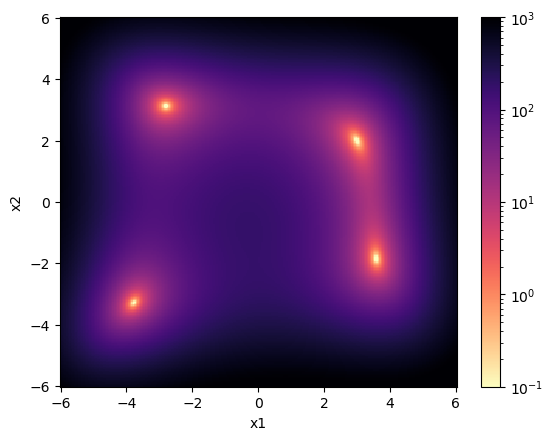

In [2]:
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

from blop.utils import functions

x1 = x2 = np.linspace(-6, 6, 256)
X1, X2 = np.meshgrid(x1, x2)

F = functions.himmelblau(X1, X2)

plt.pcolormesh(x1, x2, F, norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e3), cmap="magma_r")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")

There are several things that our agent will need. The first ingredient is some degrees of freedom (these are always `ophyd` devices) which the agent will move around to different inputs within each DOF's bounds (the second ingredient). We define these here:

In [3]:
from blop import DOF

dofs = [
    DOF(name="x1", search_domain=(-6, 6)),
    DOF(name="x2", search_domain=(-6, 6)),
]

We also need to give the agent something to do. We want our agent to look in the feedback for a variable called 'himmelblau', and try to minimize it.

In [4]:
from blop import Objective

objectives = [Objective(name="himmelblau", description="Himmeblau's function", target="min")]

In our digestion function, we define our objective as a deterministic function of the inputs:

In [5]:
def digestion(df):
    for index, entry in df.iterrows():
        df.loc[index, "himmelblau"] = functions.himmelblau(entry.x1, entry.x2)

    return df

We then combine these ingredients into an agent, giving it an instance of ``TiledWriter`` so that it can see the output of the plans it runs.

In [6]:
from blop import Agent

agent = Agent(
    dofs=dofs,
    objectives=objectives,
    digestion=digestion,
    tiled=tiled,
)

Without any data, we can't make any inferences about what the function looks like, and so we can't use any non-trivial acquisition functions. Let's start by quasi-randomly sampling the parameter space, and plotting our model of the function:

2025-05-19 15:59:28.344 INFO: Executing plan <generator object Agent.learn at 0x73652913d620>
2025-05-19 15:59:28.345 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x736560c85110> from 'idle' -> 'running'




Transient Scan ID: 1     Time: 2025-05-19 15:59:28
Persistent Unique Scan ID: '22ed613c-d4ed-4fd7-9c32-436a04433a3a'


2025-05-19 15:59:28.379 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/ "HTTP/1.1 200 OK"


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+


2025-05-19 15:59:28.390 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search//22ed613c-d4ed-4fd7-9c32-436a04433a3a?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.399 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a "HTTP/1.1 200 OK"
2025-05-19 15:59:28.407 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:28.415 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:28.423 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:28.434 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:28.440 INFO: HTTP Request: GET http://127.0.0.1:37647/ap

|         1 | 15:59:28.5 |     -1.592 |     -1.265 |


2025-05-19 15:59:28.518 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.523 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.536 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.542 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.550 INFO: HTTP Request: PUT http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         2 | 15:59:28.5 |     -2.548 |     -1.889 |


2025-05-19 15:59:28.557 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.563 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.568 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.576 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         3 | 15:59:28.5 |     -2.694 |     -4.606 |


2025-05-19 15:59:28.583 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.590 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.596 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.604 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         4 | 15:59:28.6 |     -4.743 |     -5.640 |


2025-05-19 15:59:28.611 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.617 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.623 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.630 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         5 | 15:59:28.6 |     -3.638 |     -4.334 |


2025-05-19 15:59:28.637 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.643 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.649 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.657 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         6 | 15:59:28.6 |     -3.989 |     -1.725 |


2025-05-19 15:59:28.664 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.670 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.676 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.683 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         7 | 15:59:28.6 |     -5.892 |     -0.044 |


2025-05-19 15:59:28.690 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.696 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.703 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.710 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         8 | 15:59:28.7 |     -5.193 |      0.594 |


2025-05-19 15:59:28.717 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.723 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.729 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.736 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         9 | 15:59:28.7 |     -3.832 |      1.229 |


2025-05-19 15:59:28.743 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.749 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.755 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.763 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        10 | 15:59:28.7 |     -3.299 |      1.901 |


2025-05-19 15:59:28.770 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.776 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.782 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.789 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        11 | 15:59:28.7 |     -2.368 |      1.066 |


2025-05-19 15:59:28.797 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.803 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.810 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.817 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        12 | 15:59:28.8 |     -1.226 |      2.373 |


2025-05-19 15:59:28.824 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.829 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.835 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.843 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        13 | 15:59:28.8 |      1.561 |      1.445 |


2025-05-19 15:59:28.849 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.855 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.861 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.869 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        14 | 15:59:28.8 |      2.353 |     -0.871 |


2025-05-19 15:59:28.876 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.882 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.888 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.895 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        15 | 15:59:28.8 |      1.247 |     -2.565 |


2025-05-19 15:59:28.902 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.908 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.915 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.922 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        16 | 15:59:28.9 |     -0.437 |     -2.947 |


2025-05-19 15:59:28.929 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.935 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.942 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.949 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        17 | 15:59:28.9 |     -0.835 |     -3.299 |


2025-05-19 15:59:28.956 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.962 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.969 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:28.976 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        18 | 15:59:28.9 |      0.099 |     -3.658 |


2025-05-19 15:59:28.983 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:28.989 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:28.996 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.003 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        19 | 15:59:29.0 |      2.002 |     -4.976 |


2025-05-19 15:59:29.010 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.016 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.022 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.029 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        20 | 15:59:29.0 |      3.466 |     -4.813 |


2025-05-19 15:59:29.036 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.041 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.048 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.055 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        21 | 15:59:29.0 |      5.577 |     -5.260 |


2025-05-19 15:59:29.062 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.068 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.074 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.081 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        22 | 15:59:29.0 |      4.421 |     -3.943 |


2025-05-19 15:59:29.088 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.094 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.100 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.108 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        23 | 15:59:29.1 |      3.320 |     -2.093 |


2025-05-19 15:59:29.114 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.121 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.127 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.134 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        24 | 15:59:29.1 |      5.179 |     -0.399 |


2025-05-19 15:59:29.141 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.146 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.152 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.159 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        25 | 15:59:29.1 |      5.859 |      0.224 |


2025-05-19 15:59:29.166 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.172 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.178 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.186 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        26 | 15:59:29.1 |      4.016 |      1.542 |


2025-05-19 15:59:29.193 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.199 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.205 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.213 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        27 | 15:59:29.2 |      3.617 |      4.141 |


2025-05-19 15:59:29.219 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.225 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.232 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.239 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        28 | 15:59:29.2 |      4.758 |      5.835 |


2025-05-19 15:59:29.245 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.251 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.258 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.265 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        29 | 15:59:29.2 |      2.709 |      4.800 |


2025-05-19 15:59:29.272 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.278 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.284 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.291 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        30 | 15:59:29.2 |      2.176 |      3.978 |


2025-05-19 15:59:29.298 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.304 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.311 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.318 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        31 | 15:59:29.3 |      0.815 |      3.108 |


2025-05-19 15:59:29.325 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.331 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.337 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.344 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        32 | 15:59:29.3 |      0.463 |      2.764 |


2025-05-19 15:59:29.351 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.357 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.363 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.370 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        33 | 15:59:29.3 |     -0.125 |      3.475 |


2025-05-19 15:59:29.377 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.383 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.389 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.396 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        34 | 15:59:29.3 |     -1.969 |      5.157 |


2025-05-19 15:59:29.403 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.409 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.415 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.422 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        35 | 15:59:29.4 |     -4.448 |      3.759 |


2025-05-19 15:59:29.429 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.435 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.441 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.448 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|        36 | 15:59:29.4 |     -5.545 |      5.440 |


2025-05-19 15:59:29.455 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:29.461 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:29.468 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.474 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


+-----------+------------+------------+------------+
generator list_scan ['22ed613c'] (scan num: 1)





2025-05-19 15:59:29.587 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//22ed613c-d4ed-4fd7-9c32-436a04433a3a "HTTP/1.1 200 OK"
2025-05-19 15:59:29.593 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a "HTTP/1.1 200 OK"
2025-05-19 15:59:29.600 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/22ed613c-d4ed-4fd7-9c32-436a04433a3a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:29.850 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x736560c85110> from 'running' -> 'idle'
2025-05-19 15:59:29.850 INFO: Cleaned up from plan <generator object Agent.learn at 0x73652913d620>


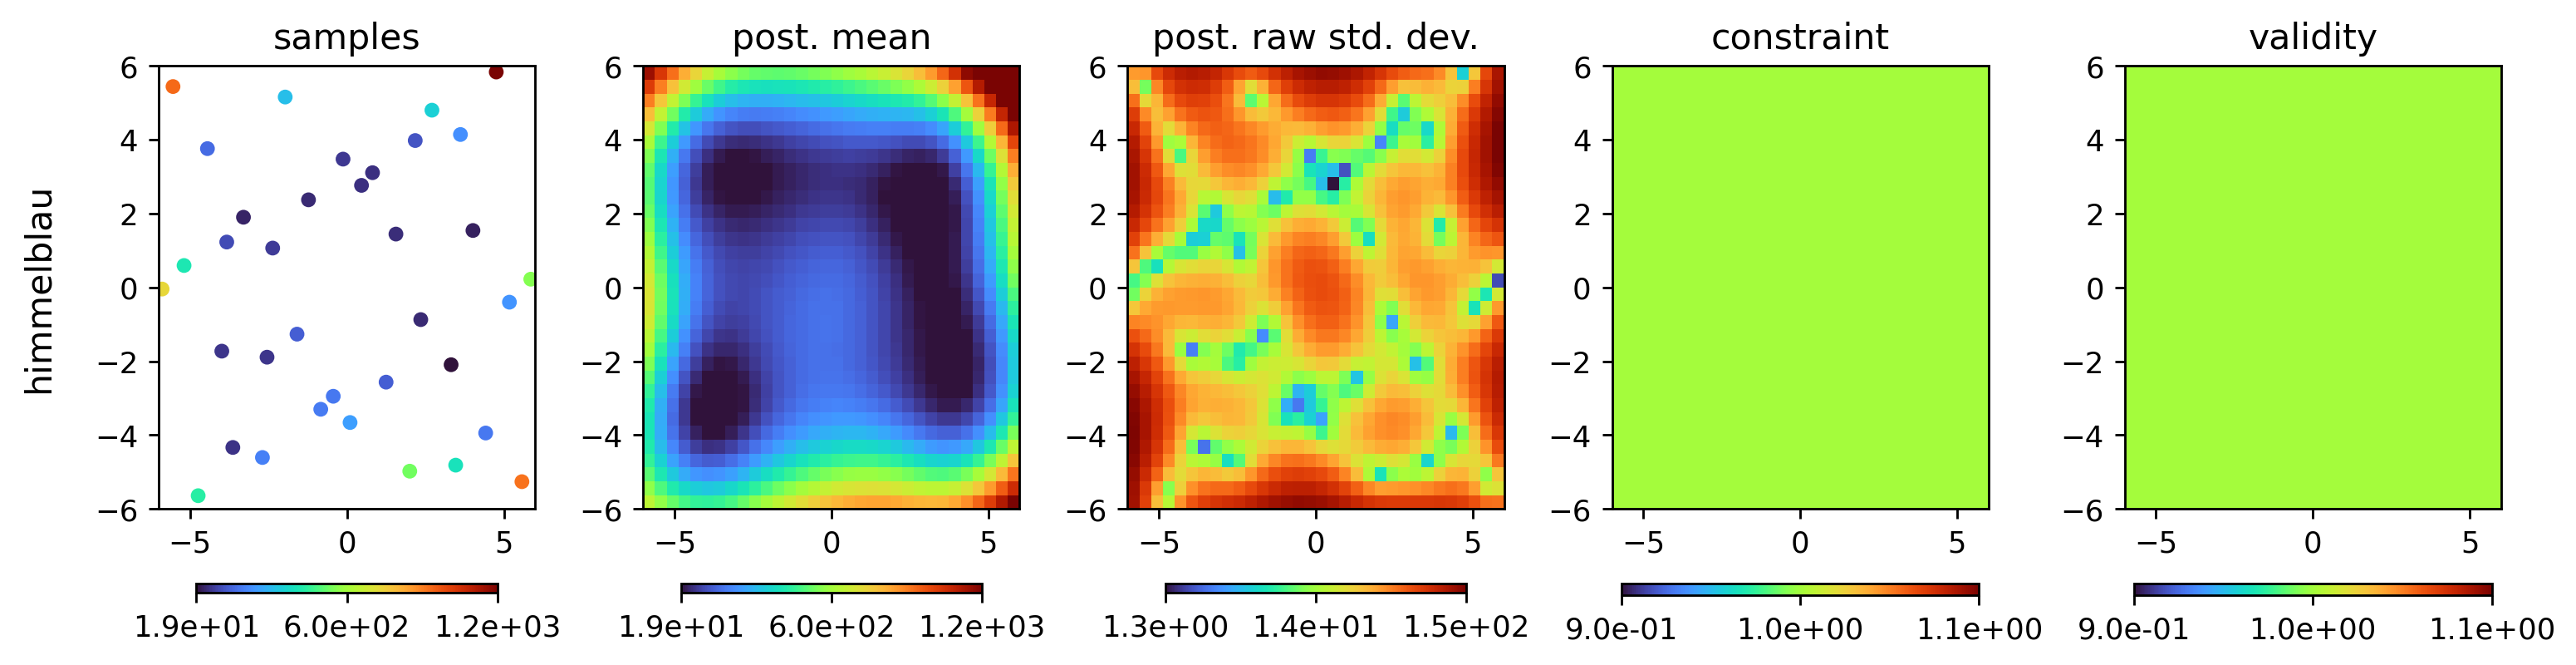

In [7]:
RE(agent.learn("quasi-random", n=36))
agent.plot_objectives()

To decide which points to sample, the agent needs an acquisition function. The available acquisition function are here:

In [8]:
agent.all_acqfs

,identifier,type,multitask_only,description
name,,,,
expected_improvement,ei,analytic,False,"The expected value of max(f(x) - \nu, 0), wher..."
expected_mean,em,analytic,False,The expected value at each input.
noisy_expected_hypervolume_improvement,nehvi,analytic,True,It's like a big box. How big is the box?
probability_of_improvement,pi,analytic,False,The probability that this input improves on th...
upper_confidence_bound,ucb,analytic,False,"The expected value, plus some multiple of the ..."
lower_bound_max_value_entropy,lbmve,monte_carlo,False,"Max entropy search, basically"
monte_carlo_expected_improvement,qei,monte_carlo,False,"The expected value of max(f(x) - \nu, 0), wher..."
monte_carlo_expected_mean,qem,monte_carlo,False,The expected value at each input.
monte_carlo_noisy_expected_hypervolume_improvement,qnehvi,monte_carlo,True,It's like a big box. How big is the box?


Now we can start to learn intelligently. Using the shorthand acquisition functions shown above, we can see the output of a few different ones:

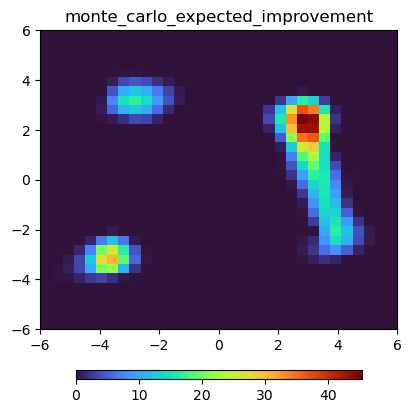

In [9]:
agent.plot_acquisition(acqf="qei")

To decide where to go, the agent will find the inputs that maximize a given acquisition function:

In [10]:
agent.ask("qei", n=1)

{'points': {'x1': [2.98814], 'x2': [2.3194017]},
 'acqf_name': 'monte_carlo_expected_improvement',
 'acqf_obj': [47.307272124034796],
 'acqf_kwargs': {'best_f': -4.792347832146621},
 'duration_ms': 38.1195570807904,
 'sequential': True,
 'upsample': 1,
 'read_only_values': tensor([], size=(1, 0))}

We can also ask the agent for multiple points to sample and it will jointly maximize the acquisition function over all sets of inputs, and find the most efficient route between them:

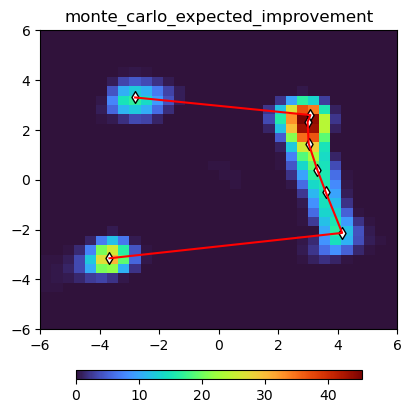

In [11]:
res = agent.ask("qei", n=8, route=True)
agent.plot_acquisition(acqf="qei")
plt.scatter(res["points"]["x1"], res["points"]["x2"], marker="d", facecolor="w", edgecolor="k")
plt.plot(res["points"]["x1"], res["points"]["x2"], color="r")

All of this is automated inside the ``learn`` method, which will find a point (or points) to sample, sample them, and retrain the model and its hyperparameters with the new data. To do 4 learning iterations of 8 points each, we can run

In [12]:
RE(agent.learn("qei", n=4, iterations=8))

2025-05-19 15:59:32.458 INFO: Executing plan <generator object Agent.learn at 0x73644bfa9df0>
2025-05-19 15:59:32.459 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x736560c85110> from 'idle' -> 'running'




Transient Scan ID: 2     Time: 2025-05-19 15:59:33
Persistent Unique Scan ID: '755c0bf6-fa39-40db-ad2d-5ebdb335190a'


2025-05-19 15:59:33.060 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/ "HTTP/1.1 200 OK"


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+


2025-05-19 15:59:33.072 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search//755c0bf6-fa39-40db-ad2d-5ebdb335190a?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:33.080 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//755c0bf6-fa39-40db-ad2d-5ebdb335190a "HTTP/1.1 200 OK"
2025-05-19 15:59:33.088 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:33.095 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:33.103 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:33.111 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:33.116 INFO: HTTP Request: GET http://127.0.0.1:37647/ap

|         1 | 15:59:33.1 |     -2.815 |      3.286 |


2025-05-19 15:59:33.186 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:33.192 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:33.204 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:33.210 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:33.218 INFO: HTTP Request: PUT http://127.0.0.1:37647/api/v1/table/partition/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         2 | 15:59:33.2 |      2.988 |      2.319 |


2025-05-19 15:59:33.225 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:33.231 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:33.238 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:33.245 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         3 | 15:59:33.2 |      3.317 |      0.390 |


2025-05-19 15:59:33.253 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:33.259 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:33.266 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:33.273 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         4 | 15:59:33.2 |     -3.675 |     -3.147 |


2025-05-19 15:59:33.280 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:33.286 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:33.292 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:33.300 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


+-----------+------------+------------+------------+
generator list_scan ['755c0bf6'] (scan num: 2)





2025-05-19 15:59:33.413 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//755c0bf6-fa39-40db-ad2d-5ebdb335190a "HTTP/1.1 200 OK"
2025-05-19 15:59:33.419 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/755c0bf6-fa39-40db-ad2d-5ebdb335190a "HTTP/1.1 200 OK"
2025-05-19 15:59:33.426 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/755c0bf6-fa39-40db-ad2d-5ebdb335190a/primary/internal/events "HTTP/1.1 200 OK"




Transient Scan ID: 3     Time: 2025-05-19 15:59:34
Persistent Unique Scan ID: '926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e'


2025-05-19 15:59:34.446 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/ "HTTP/1.1 200 OK"


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+


2025-05-19 15:59:34.455 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search//926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:34.466 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e "HTTP/1.1 200 OK"
2025-05-19 15:59:34.474 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:34.481 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:34.489 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:34.496 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:34.502 INFO: HTTP Request: GET http://127.0.0.1:37647/ap

|         1 | 15:59:34.5 |      3.816 |     -2.567 |


2025-05-19 15:59:34.570 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:34.575 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:34.586 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:34.592 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:34.600 INFO: HTTP Request: PUT http://127.0.0.1:37647/api/v1/table/partition/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         2 | 15:59:34.6 |      3.948 |     -2.106 |


2025-05-19 15:59:34.607 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:34.612 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:34.618 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:34.626 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         3 | 15:59:34.6 |      3.673 |     -1.148 |


2025-05-19 15:59:34.633 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:34.638 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:34.645 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:34.653 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         4 | 15:59:34.6 |      3.171 |      1.508 |


2025-05-19 15:59:34.660 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:34.665 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:34.672 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:34.679 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


+-----------+------------+------------+------------+
generator list_scan ['926c90c6'] (scan num: 3)





2025-05-19 15:59:34.791 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e "HTTP/1.1 200 OK"
2025-05-19 15:59:34.798 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e "HTTP/1.1 200 OK"
2025-05-19 15:59:34.804 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e/primary/internal/events "HTTP/1.1 200 OK"




Transient Scan ID: 4     Time: 2025-05-19 15:59:36
Persistent Unique Scan ID: '6baa7ddb-7afd-4a3a-be3a-28fa8b114959'


2025-05-19 15:59:36.566 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/ "HTTP/1.1 200 OK"


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+


2025-05-19 15:59:36.575 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search//6baa7ddb-7afd-4a3a-be3a-28fa8b114959?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:36.582 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//6baa7ddb-7afd-4a3a-be3a-28fa8b114959 "HTTP/1.1 200 OK"
2025-05-19 15:59:36.590 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:36.597 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:36.605 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:36.613 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:36.619 INFO: HTTP Request: GET http://127.0.0.1:37647/ap

|         1 | 15:59:36.6 |      3.338 |      2.214 |


2025-05-19 15:59:36.688 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:36.693 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:36.705 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:36.711 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:36.718 INFO: HTTP Request: PUT http://127.0.0.1:37647/api/v1/table/partition/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         2 | 15:59:36.7 |     -2.537 |      2.986 |


2025-05-19 15:59:36.726 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:36.732 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:36.738 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:36.745 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         3 | 15:59:36.7 |     -3.127 |      3.037 |


2025-05-19 15:59:36.752 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:36.758 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:36.763 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:36.770 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         4 | 15:59:36.7 |     -4.035 |     -3.400 |


2025-05-19 15:59:36.778 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:36.784 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:36.790 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:36.797 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


+-----------+------------+------------+------------+
generator list_scan ['6baa7ddb'] (scan num: 4)





2025-05-19 15:59:36.909 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//6baa7ddb-7afd-4a3a-be3a-28fa8b114959 "HTTP/1.1 200 OK"
2025-05-19 15:59:36.915 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/6baa7ddb-7afd-4a3a-be3a-28fa8b114959 "HTTP/1.1 200 OK"
2025-05-19 15:59:36.921 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/6baa7ddb-7afd-4a3a-be3a-28fa8b114959/primary/internal/events "HTTP/1.1 200 OK"




Transient Scan ID: 5     Time: 2025-05-19 15:59:38
Persistent Unique Scan ID: 'c258d277-5be3-43dc-ba25-d9325f199d7d'


2025-05-19 15:59:38.015 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/ "HTTP/1.1 200 OK"


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+


2025-05-19 15:59:38.024 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search//c258d277-5be3-43dc-ba25-d9325f199d7d?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:38.031 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//c258d277-5be3-43dc-ba25-d9325f199d7d "HTTP/1.1 200 OK"
2025-05-19 15:59:38.039 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//c258d277-5be3-43dc-ba25-d9325f199d7d/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:38.046 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//c258d277-5be3-43dc-ba25-d9325f199d7d/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:38.053 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//c258d277-5be3-43dc-ba25-d9325f199d7d/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:38.060 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//c258d277-5be3-43dc-ba25-d9325f199d7d/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:38.066 INFO: HTTP Request: GET http://127.0.0.1:37647/ap

|         1 | 15:59:38.1 |     -3.788 |     -3.354 |


2025-05-19 15:59:38.133 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:38.138 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:38.150 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:38.156 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:38.162 INFO: HTTP Request: PUT http://127.0.0.1:37647/api/v1/table/partition/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         2 | 15:59:38.1 |      3.564 |     -1.746 |


2025-05-19 15:59:38.169 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:38.175 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:38.181 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:38.188 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         3 | 15:59:38.1 |      2.920 |      1.952 |


2025-05-19 15:59:38.195 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:38.201 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:38.207 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:38.214 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         4 | 15:59:38.2 |      2.462 |      2.619 |


2025-05-19 15:59:38.221 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:38.227 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:38.233 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:38.240 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


+-----------+------------+------------+------------+
generator list_scan ['c258d277'] (scan num: 5)





2025-05-19 15:59:38.353 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//c258d277-5be3-43dc-ba25-d9325f199d7d "HTTP/1.1 200 OK"
2025-05-19 15:59:38.359 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/c258d277-5be3-43dc-ba25-d9325f199d7d "HTTP/1.1 200 OK"
2025-05-19 15:59:38.365 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/c258d277-5be3-43dc-ba25-d9325f199d7d/primary/internal/events "HTTP/1.1 200 OK"
/home/jmoylan1/Documents/Github/blop/.pixi/envs/default/lib/python3.11/site-packages/botorch/optim/optimize.py:273: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  candidate, acq_value = _optimize_acqf_batch(new_inputs)




Transient Scan ID: 6     Time: 2025-05-19 15:59:40
Persistent Unique Scan ID: '738a55d1-1992-4387-ba71-7c9b1d04af27'


2025-05-19 15:59:40.177 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/ "HTTP/1.1 200 OK"


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+


2025-05-19 15:59:40.186 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search//738a55d1-1992-4387-ba71-7c9b1d04af27?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:40.193 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//738a55d1-1992-4387-ba71-7c9b1d04af27 "HTTP/1.1 200 OK"
2025-05-19 15:59:40.201 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//738a55d1-1992-4387-ba71-7c9b1d04af27/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:40.209 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//738a55d1-1992-4387-ba71-7c9b1d04af27/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:40.217 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//738a55d1-1992-4387-ba71-7c9b1d04af27/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:40.225 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//738a55d1-1992-4387-ba71-7c9b1d04af27/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:40.231 INFO: HTTP Request: GET http://127.0.0.1:37647/ap

|         1 | 15:59:40.2 |     -2.258 |      3.315 |


2025-05-19 15:59:40.301 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:40.306 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:40.318 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:40.324 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:40.331 INFO: HTTP Request: PUT http://127.0.0.1:37647/api/v1/table/partition/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         2 | 15:59:40.3 |     -3.827 |     -3.219 |


2025-05-19 15:59:40.337 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:40.343 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:40.349 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:40.356 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         3 | 15:59:40.3 |      3.375 |     -1.529 |


2025-05-19 15:59:40.363 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:40.369 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:40.375 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:40.381 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         4 | 15:59:40.3 |      3.607 |     -1.939 |


2025-05-19 15:59:40.388 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:40.394 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:40.400 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:40.406 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


+-----------+------------+------------+------------+
generator list_scan ['738a55d1'] (scan num: 6)





2025-05-19 15:59:40.519 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//738a55d1-1992-4387-ba71-7c9b1d04af27 "HTTP/1.1 200 OK"
2025-05-19 15:59:40.525 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/738a55d1-1992-4387-ba71-7c9b1d04af27 "HTTP/1.1 200 OK"
2025-05-19 15:59:40.532 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/738a55d1-1992-4387-ba71-7c9b1d04af27/primary/internal/events "HTTP/1.1 200 OK"




Transient Scan ID: 7     Time: 2025-05-19 15:59:41
Persistent Unique Scan ID: 'ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b'


2025-05-19 15:59:41.515 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/ "HTTP/1.1 200 OK"


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+


2025-05-19 15:59:41.524 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search//ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:41.532 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b "HTTP/1.1 200 OK"
2025-05-19 15:59:41.539 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:41.546 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:41.553 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:41.561 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:41.567 INFO: HTTP Request: GET http://127.0.0.1:37647/ap

|         1 | 15:59:41.6 |      3.577 |     -1.845 |


2025-05-19 15:59:41.638 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:41.644 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:41.657 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:41.665 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:41.674 INFO: HTTP Request: PUT http://127.0.0.1:37647/api/v1/table/partition/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         2 | 15:59:41.6 |      3.573 |     -0.371 |


2025-05-19 15:59:41.681 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:41.687 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:41.694 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:41.701 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         3 | 15:59:41.7 |      2.833 |      1.579 |


2025-05-19 15:59:41.708 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:41.714 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:41.720 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:41.728 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         4 | 15:59:41.7 |     -2.786 |      3.123 |


2025-05-19 15:59:41.734 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:41.740 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:41.747 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:41.754 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


+-----------+------------+------------+------------+
generator list_scan ['ba7ed1d5'] (scan num: 7)





2025-05-19 15:59:41.867 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b "HTTP/1.1 200 OK"
2025-05-19 15:59:41.873 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b "HTTP/1.1 200 OK"
2025-05-19 15:59:41.879 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b/primary/internal/events "HTTP/1.1 200 OK"




Transient Scan ID: 8     Time: 2025-05-19 15:59:42
Persistent Unique Scan ID: 'ea6b47f5-2ed3-46b8-bacf-8b2272c41833'


2025-05-19 15:59:42.373 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/ "HTTP/1.1 200 OK"


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+


2025-05-19 15:59:42.382 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search//ea6b47f5-2ed3-46b8-bacf-8b2272c41833?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:42.390 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//ea6b47f5-2ed3-46b8-bacf-8b2272c41833 "HTTP/1.1 200 OK"
2025-05-19 15:59:42.398 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:42.405 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:42.413 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:42.421 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:42.426 INFO: HTTP Request: GET http://127.0.0.1:37647/ap

|         1 | 15:59:42.4 |     -2.783 |      3.142 |


2025-05-19 15:59:42.496 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:42.501 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:42.516 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:42.523 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:42.530 INFO: HTTP Request: PUT http://127.0.0.1:37647/api/v1/table/partition/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         2 | 15:59:42.5 |     -2.722 |      3.165 |


2025-05-19 15:59:42.537 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:42.543 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:42.549 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:42.557 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         3 | 15:59:42.5 |      2.963 |      2.060 |


2025-05-19 15:59:42.564 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:42.570 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:42.576 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:42.583 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         4 | 15:59:42.5 |      3.045 |      1.943 |


2025-05-19 15:59:42.590 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:42.596 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:42.602 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:42.609 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


+-----------+------------+------------+------------+
generator list_scan ['ea6b47f5'] (scan num: 8)





2025-05-19 15:59:42.722 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//ea6b47f5-2ed3-46b8-bacf-8b2272c41833 "HTTP/1.1 200 OK"
2025-05-19 15:59:42.728 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ea6b47f5-2ed3-46b8-bacf-8b2272c41833 "HTTP/1.1 200 OK"
2025-05-19 15:59:42.735 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ea6b47f5-2ed3-46b8-bacf-8b2272c41833/primary/internal/events "HTTP/1.1 200 OK"
/home/jmoylan1/Documents/Github/blop/.pixi/envs/default/lib/python3.11/site-packages/botorch/optim/optimize.py:273: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  candidate, acq_value = _optimize_acqf_batch(new_inputs)




Transient Scan ID: 9     Time: 2025-05-19 15:59:43
Persistent Unique Scan ID: 'ccb73604-d887-4975-b51e-c8c7d02bbc53'


2025-05-19 15:59:43.259 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/ "HTTP/1.1 200 OK"


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+


2025-05-19 15:59:43.268 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search//ccb73604-d887-4975-b51e-c8c7d02bbc53?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:43.275 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//ccb73604-d887-4975-b51e-c8c7d02bbc53 "HTTP/1.1 200 OK"
2025-05-19 15:59:43.282 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//ccb73604-d887-4975-b51e-c8c7d02bbc53/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:43.290 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//ccb73604-d887-4975-b51e-c8c7d02bbc53/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:43.297 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata//ccb73604-d887-4975-b51e-c8c7d02bbc53/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:43.305 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//ccb73604-d887-4975-b51e-c8c7d02bbc53/primary "HTTP/1.1 200 OK"
2025-05-19 15:59:43.311 INFO: HTTP Request: GET http://127.0.0.1:37647/ap

|         1 | 15:59:43.3 |      3.017 |      1.979 |


2025-05-19 15:59:43.383 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:43.388 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:43.399 INFO: HTTP Request: POST http://127.0.0.1:37647/api/v1/metadata/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:43.405 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:43.412 INFO: HTTP Request: PUT http://127.0.0.1:37647/api/v1/table/partition/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         2 | 15:59:43.4 |      2.961 |      2.052 |


2025-05-19 15:59:43.419 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:43.426 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:43.432 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:43.439 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         3 | 15:59:43.4 |      2.861 |      2.106 |


2025-05-19 15:59:43.446 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:43.452 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:43.458 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:43.466 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


|         4 | 15:59:43.4 |      3.579 |     -1.842 |


2025-05-19 15:59:43.472 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata//ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal "HTTP/1.1 200 OK"
2025-05-19 15:59:43.478 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/search/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-05-19 15:59:43.485 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal/events "HTTP/1.1 200 OK"
2025-05-19 15:59:43.492 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/table/partition/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


+-----------+------------+------------+------------+
generator list_scan ['ccb73604'] (scan num: 9)





2025-05-19 15:59:43.605 INFO: HTTP Request: PATCH http://127.0.0.1:37647/api/v1/metadata//ccb73604-d887-4975-b51e-c8c7d02bbc53 "HTTP/1.1 200 OK"
2025-05-19 15:59:43.611 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ccb73604-d887-4975-b51e-c8c7d02bbc53 "HTTP/1.1 200 OK"
2025-05-19 15:59:43.617 INFO: HTTP Request: GET http://127.0.0.1:37647/api/v1/metadata/ccb73604-d887-4975-b51e-c8c7d02bbc53/primary/internal/events "HTTP/1.1 200 OK"
/home/jmoylan1/Documents/Github/blop/.pixi/envs/default/lib/python3.11/site-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  warn(
2025-05-19 15:59:43.800 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x736560c85110> from 'running' -> 'idle'
2025-05-19 15:59:43.801 INFO: Cleaned up from plan <generator object Agent.learn at 0x73644bfa9df0>


('755c0bf6-fa39-40db-ad2d-5ebdb335190a',
 '926c90c6-52a5-4a3e-8f56-33bd7a1e4a6e',
 '6baa7ddb-7afd-4a3a-be3a-28fa8b114959',
 'c258d277-5be3-43dc-ba25-d9325f199d7d',
 '738a55d1-1992-4387-ba71-7c9b1d04af27',
 'ba7ed1d5-f6cb-4f5b-bed8-58d4fb913a0b',
 'ea6b47f5-2ed3-46b8-bacf-8b2272c41833',
 'ccb73604-d887-4975-b51e-c8c7d02bbc53')

Our agent has found all the global minima of Himmelblau's function using Bayesian optimization, and we can ask it for the best point: 

x1                                    3.579089
x2                                   -1.841774
himmelblau                            0.001846
seq_num                                      4
ts_x1                        1747684783.466893
ts_x2                         1747684783.46712
acqf          monte_carlo_expected_improvement
Name: 67, dtype: object


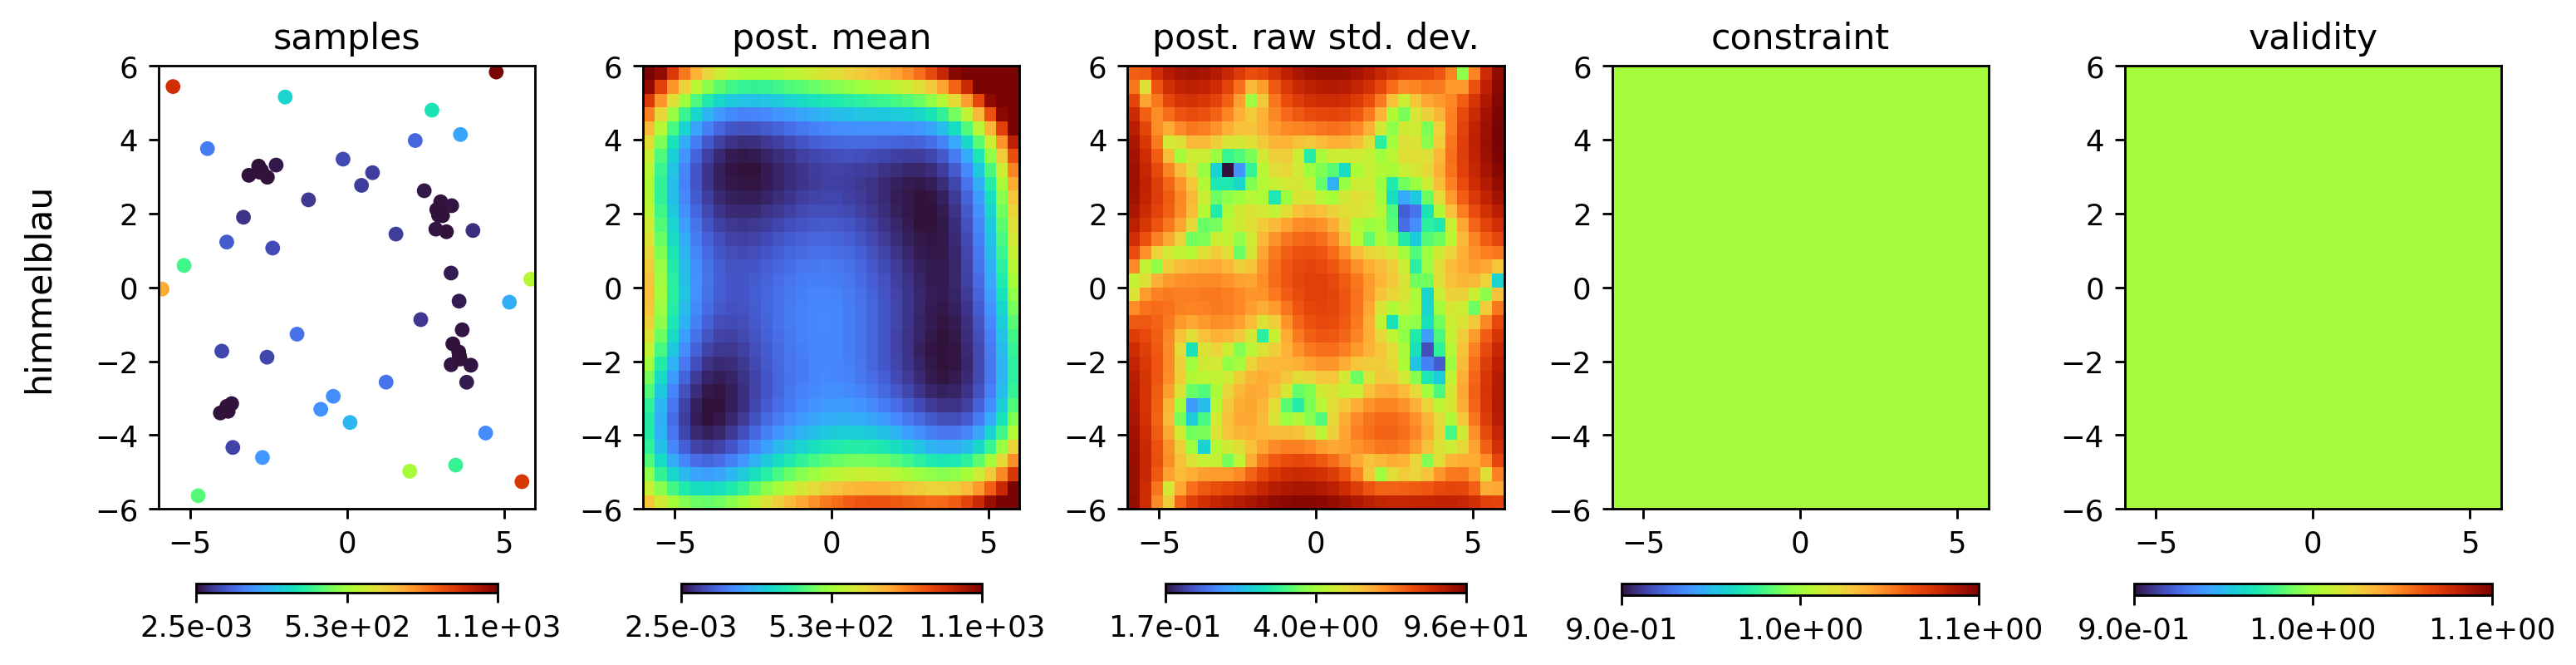

In [13]:
agent.plot_objectives()
print(agent.best)

In [14]:
tiled_server.close()